<img src="http://landlab.github.io/assets/Landlab-logo.png"
style="float:left;width:150px;padding:0px">  

<br /> 

# Notebook: Add interesting data to a Landlab grid and create a netcdf 

### You will explore how to reuse model code and data in a subregion within a larger region where the model was developed 
* Load data from a regional Landlab landslide model (Strauch et al., 2018) developed for the North Cascades National Park, WA USA, published on HydroShare. <br />
* Define a geographic subset (Thunder Creek watershed) within the study region.
* Explore landslide probability sensitivity to fire by adjusting the cohesion parameter for Thunder Creek.
* Save results to a new HydroShare resource.  <br />

The shallow landslide model you will is based on a spatially distributed Monte Carlo solution of the infinite slope stability model. Detailes of the model and the study site are described in Strauch et al. (2018). Please see the end of this Notebook for Acknowledgements and Citation information. 

 <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:10px">   

## To run this notebook:

Click in each shaded cell below and "shift + enter" to run each code block. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting your run options from the pull-down menu. This is also where you can clear outputs from previous runs.

If an error occurs, click on *Kernal* and *Restart and Clear Outputs* in the menu above.

## 1. Introduction



### 2.1.2 Import Landlab libraries in development, Python libraries and Landlab 2.1.1 functions

In [12]:
#Import standard Python utilities for calculating and plotting
import six 
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle as pickle
from datetime import datetime, timedelta
#import geopandas as gpd

# Import Landlab libraries
import landlab
from landlab.io.netcdf import write_netcdf  
from landlab.io.netcdf import read_netcdf  
from landlab import imshow_grid_at_node
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from landlab.plot import imshow_grid
# Import Landlab Landslide component libraries
from landlab.components.landslides import LandslideProbability
import numpy as np
from landlab import RasterModelGrid
from landlab.io.netcdf import write_raster_netcdf
from landlab.io.netcdf import read_netcdf

#Import utilities for importing and exporting to HydroShare
#import sys
#!{sys.executable} -m pip install hstools
#from hstools import hydroshare

# Import general tools
import time
from collections import defaultdict
st = time.time()
%matplotlib inline

### 2.1.3 Connection and download with HydroShare
After importing libraires, we now establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare.

In [11]:
resource_id = '01b486f301864828ba2cd9ab7ac77c4e'
import json
import os
from hs_restclient import HydroShare, HydroShareAuthOAuth2
oauth = json.loads(os.environ["HS_AUTH"])
auth = HydroShareAuthOAuth2(oauth[1], "", token=oauth[0])
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### 2.2. Cyberinfrastructure methods
Strauch et al (2018) pre-processed the data for the North Cascades National Park Complex case study and is on HydroShare as [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/). Here the first task is find this resource on Hydrohsare. We will click on the link to see the published data repository on HydroShare and collect the resource ID of the data. The resource ID can be found in the "How to cite" box, and it will be the series of numbers and letters following "hs.". Here's the copied resource: http://dx.doi.org/10.4211/hs.a5b52c0e1493401a815f4e77b09d352b citation. Now we copy this ID and introduce it as "Data_ResourceID=" in the code below. 

#### 2.2.1 Set DEM data download variable name
To learn more about this data visit [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/)

In [ ]:
!pwd

#### 2.2.2 Download Data
We will execute the next cell to download data from HydroShare iRods database to your personal user space - this may take a few minutes.

This only needs to happen one time to transfer data from Github storage to the JupyterHub server workspace. 

In [19]:
#!mkdir '/home/jovyan/work/Github'
#os.chdir('/home/jovyan/work/Github')
#!pwd
#!git clone https://github.com/Freshwater-Initiative/SkagitLandslideHazards.git

/home/jovyan/work/Github
Cloning into 'SkagitLandslideHazards'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 346 (delta 41), reused 63 (delta 17), pack-reused 237
Receiving objects: 100% (346/346), 64.84 MiB | 23.55 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Checking out files: 100% (124/124), done.


In [20]:
os.chdir('/home/jovyan/work/Github/SkagitLandslideHazards/notebooks')

This Github folder is: /home/jovyan/work/Github/SkagitLandslideHazards/notebooks


In [39]:
github_folder = '/home/jovyan/work/Github/SkagitLandslideHazards/notebooks'
print('This Github folder is: %s' % github_folder)

hydroshare_folder = '/home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents'

data_folder = hydroshare_folder +'/ASCII_Files/'
print('This HydroShare resource has been downloaded to: %s' % data_folder)

landslide_folder =  hydroshare_folder +'/ASCII_Files/'
print('This HydroShare resource with Landlab model input GIS data has just been downloaded has been downloaded to: %s' % landslide_folder)

dhsvm_folder =  hydroshare_folder +'/DHSVM/'
print('This HydroShare resource with Hydrology Model data  has been downloaded to: %s' % dhsvm_folder)

dates_folder = hydroshare_folder +'DHSVM/dates_max_sat_skagit'
print('This HydroShare resource with storm dates printed from the hydrology model has been downloaded to: %s' % dates_folder)

netcdf_folder = hydroshare_folder +'/netcdf/'
print('The netcdf inputs/outputs is in: %s' % netcdf_folder)
#!mkdir netcdf_folder

This Github folder is: /home/jovyan/work/Github/SkagitLandslideHazards/notebooks
This HydroShare resource has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/ASCII_Files/
This HydroShare resource with Landlab model input GIS data has just been downloaded has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/ASCII_Files/
This HydroShare resource with Hydrology Model data  has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/DHSVM/
This HydroShare resource with storm dates printed from the hydrology model has been downloaded to: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contentsDHSVM/dates_max_sat_skagit
The netcdf inputs/outputs is in: /home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01

#### Load  spatial landslide model inputs from ASCII textfile (ArcGIS raster conversion) into Landlab grid

Create Landlab RasterModelGrid using DEM grid with elevation - this takes approximately 60 sec for the North Cascades National Park (NOCA). 

In [25]:
(grid, z) = read_esri_ascii(data_folder+'/scl_dem_30m.txt',name='topographic__elevation')
grid.at_node.keys()
grid.set_nodata_nodes_to_closed(z, -9999.0)

In [26]:
grid.at_node.keys()

dict_keys(['topographic__elevation'])

Plot the elevation grid of NOCA

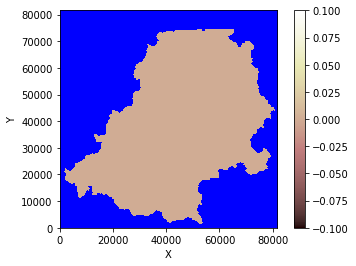

In [27]:
imshow_grid(grid, grid.status_at_node, color_for_closed='blue')

Confirm the size of the grid, nodes located every 30 m.

In [28]:
#grid?

In [29]:
print(grid.at_node.keys())
gridnum = grid.number_of_nodes
print(gridnum)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], -9999.)
print(grid.at_node['topographic__elevation'])

dict_keys(['topographic__elevation'])
7412000
[-9999. -9999. -9999. ..., -9999. -9999. -9999.]


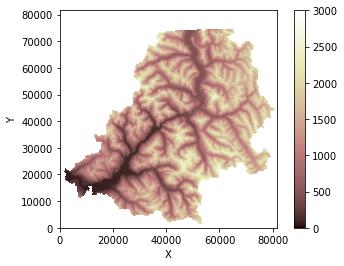

In [30]:
imshow_grid(grid, 'topographic__elevation', limits=(0, 3000), color_for_closed='white')

In [41]:
#temp_dir = tempfile.mkdtemp()
#os.chdir(temp_dir)
os.chdir(netcdf_folder)
!pwd

/home/jovyan/work/Downloads/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/netcdf


In [34]:
write_raster_netcdf("SCL_elevationNETCDF4.nc", grid, format="NETCDF4", names="topographic__elevation")

### 2.5a. Attach data (e.g., soil and vegetation variables) to the Landlab rastermodelgrid
This will be used to calculate shallow landslide probability and set boundary conditions. THe data we attach in this step was downloaded in Step 2.2.2. 

#### Run the landlab_unitgrid file we built for this publication using Seattle City Light domain data

### 2.5b. Attach data (e.g., soil and vegetation variables) to the Landlab rastermodelgrid
This will be used to calculate shallow landslide probability and set boundary conditions. THe data we attach in this step was downloaded in Step 2.2.2. 

#### For each input below
1. Load data from ascii text file
2. Add this data as node variable to the Thunder Creek grid
3. Set boundary conditions

For the entire NOCA extent, this takes ~60 sec to load each file using the CUAHSI JupyterHub server. 

#### 2.5.8 Load observed landslide inventory. Class 1-5 are landslides, 8 is no landslide mapped for later plotting

In [ ]:
(grid1, slides) = read_esri_ascii(data_folder+'/noca_landslidetype.txt')
grid.add_field('node', 'landslides', slides)

#### 2.5.8 Load landcover classes to use for examining patterns in results. 
There are 8 classes: forest (41), shrubs (52), herbaceous (71), wetland (90), developed (21), barren (31), ice & snow (12), and water (11). Exclude the last 2 classes from analysis as landslides based on this approach are not modeled in water bodies.

In [ ]:
(grid1, lulc) = read_esri_ascii(data_folder+'/scl_lulc_8c.txt')
grid.add_field('node', 'landcover', lulc)
grid.set_nodata_nodes_to_closed(grid.at_node['landcover'], 12)
grid.set_nodata_nodes_to_closed(grid.at_node['landcover'], 11)

#### 2.5.9 Load area of Goodell Creek Fire (2015) located within Skagit River Watershed. 
Use this area to adjust root cohesion.

In [ ]:
(grid1, fire) = read_esri_ascii(data_folder+'/goodell_fire.txt')
grid.add_field('node', 'fire_mask', fire)
#grid.set_nodata_nodes_to_closed(grid.at_node['fire_mask'], -9999)

#### 2.5.10  Load area of mapped glaciers and exclude from analysis.

In [ ]:
(grid1, glaciers) = read_esri_ascii(data_folder+'/glacier_scl_exclusion.txt')
grid.add_field('node', 'glacier_mask', glaciers)
grid.set_nodata_nodes_to_closed(grid.at_node['glacier_mask'], 1)

#### Write netcdf

In [ ]:
write_raster_netcdf(
    "SCL_elevation+obs+lc+fire+gl+NETCDF4.nc", 
    grid, 
    format="NETCDF4", 
    names=["topographic__elevation", 'landslides','landcover','fire_mask', 'glacier_mask']
)

#### Sanity check netcdf

In [ ]:
SCLplus_4 = read_netcdf('SCL_elevation+obs+lc+fire+gl+NETCDF4.nc')
print(SCLplus_4.at_node['topographic__elevation'])
print(SCLplus_4.at_node['landslides'])
longlist=SCLplus_4.at_node['topographic__elevation'][:].flatten()
print(longlist.shape)
print(grid.shape)

In [45]:
PushNotebook='observedlandslides_data+landlab+netcdf.ipynb' #check name for consistency
files=[os.path.join(github_folder, ThisNotebook)]
files


['/home/jovyan/work/Github/SkagitLandslideHazards/notebooks/observedlandslides_data+landlab+netcdf.ipynb']

In [47]:
!ls '/home/jovyan/work/Github/SkagitLandslideHazards/notebooks'

20200331_map2netcdf2array_lognormal_spatial_Depth_SCL_LandlabLandslide.ipynb
SCL_elevationNETCDF4.nc
SCL_uniform_landslide_20191207.ipynb



[ERROR] invalid path: /home/jovyan/work/Github/SkagitLandslideHazards/notebooks/observedlandslides_data+landlab+netcdf.ipynb


## 4.0. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.


***Option A*** : define the resource from which this "NEW" content has been derived.  This is one method for tracking resource provenance.

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
help(hs)

### Acknowledgements


[![DOI](https://zenodo.org/badge/187289993.svg)](https://zenodo.org/badge/latestdoi/187289993)

This Notebooks serves as content for: 

Bandaragoda, C. J., A. Castronova, E. Istanbulluoglu, R. Strauch, S. S. Nudurupati, J. Phuong, J. M. Adams, et al. “Enabling Collaborative Numerical Modeling in Earth Sciences Using Knowledge Infrastructure.” Environmental Modelling & Software, April 24, 2019. https://doi.org/10.1016/j.envsoft.2019.03.020.

and 

Bandaragoda, C., A. M. Castronova, J. Phuong, E. Istanbulluoglu, S. S. Nudurupati, R. Strauch, N. Lyons, K. Barnhart (2019). Enabling Collaborative Numerical Modeling in Earth Sciences using Knowledge Infrastructure: Landlab Notebooks, HydroShare, http://www.hydroshare.org/resource/fdc3a06e6ad842abacfa5b896df73a76

This notebook was developed from code written by Ronda Strauch as part of her Ph.D. disseration at the University of Washington. 

Use or citation of this notebook should also reference:

Strauch R., Istanbulluoglu E., Nudurupati S.S., Bandaragoda C., Gasparini N.M., and G.E. Tucker (2018). A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surf. Dynam., 6, 1–26. 
https://www.earth-surf-dynam.net/6/1/2018/